<a href="https://colab.research.google.com/github/Tkag0001/Practice_NLP_with_transformer/blob/main/Multilingual_named_entity_recognition_chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The dataset: Pan-x

In [ ]:
!pip install datasets

In [ ]:
from datasets import get_dataset_config_names

In [ ]:
xtreme_subsets = get_dataset_config_names('xtreme')
print(f"XTREME has {len(xtreme_subsets)} configurations")

In [ ]:
# Search configurations start with "PAN"
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

In [ ]:
# we have some .code to represent language such as
# German(de), French(fr), Italian(it), English(en)
from datasets import load_dataset
load_dataset('xtreme', name = 'PAN-X.de')

In [ ]:
#keys and propotions each languages
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

# will return a datasetdict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # Load monolingual corpus
  ds = load_dataset('xtreme', name = f'PAN-X.{lang}')

  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed = 0) #prevent accidentally bias
        .select(range(int(frac * ds[split].num_rows)))
    )

In [7]:
langs

['de', 'fr', 'it', 'en']

In [8]:
# number of samples in training
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index = ["Number of trainig examples"])

,de,fr,it,en
Number of trainig examples,12580,4580,1680,1180


In [9]:
# perform zero-shot cross-lingual transfer to German
element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
panx_ch['de']['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [11]:
# ner_tags column corresponds to the mapping of each entity to a class ID.
# Let's create a new column with the familiar LOC, PER, and ORG tags.

for key, value in panx_ch['de']['train'].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [12]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [13]:
# we use ClassLabel.int2str() in chapter 2 to create new column with class names for each tag
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch['de'].map(create_tag_names)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [14]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [15]:
de_example = panx_de["train"][2]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Tokens,Dirigenten,von,Weltruf,wie,Wilhelm,Furtwängler,",",Erich,Kleiber,",",...,haben,seine,Werke,dirigiert,",",zuletzt,besonders,Horst,Stein,.
Tags,O,O,O,O,B-PER,I-PER,O,B-PER,I-PER,O,...,O,O,O,O,O,O,O,B-PER,I-PER,O


In [16]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient = 'index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


#Tokenization

In [17]:
# Compare results between BERT and XLM-R tokenizer
from transformers import AutoTokenizer

bert_model_name = 'bert-base-uncased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [18]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [19]:
bert_tokens

['[CLS]', 'jack', 'sparrow', 'loves', 'new', 'york', '!', '[SEP]']

In [20]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [21]:
pd.DataFrame([bert_tokens, xlmr_tokens],index = ['bert', 'xlmr'])

,0,1,2,3,4,5,6,7,8,9
bert,[CLS],jack,sparrow,loves,new,york,!,[SEP],None,None
xlmr,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


**We can see that instead of using [CLS], [SEP], xlmr use s and /s. It's like html tag**

# The tokenizer pipeline
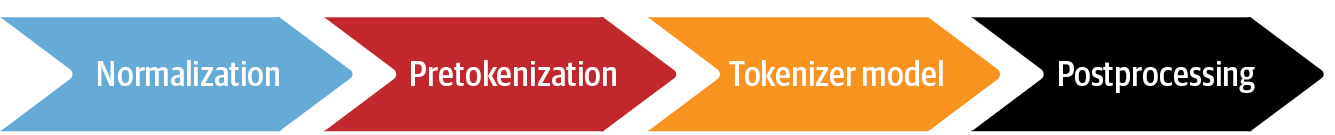

# The SentencePiece Tokenizer

In [22]:
# The weakness of previous model word piece, it lost the infor mation of
# whitespace between "York" and "!". With SentencePiece, the character '_'
# represent whitespace, so the model can detect where whitespace
''.join(xlmr_tokens).replace(u'\u2581',' ')

'<s> Jack Sparrow loves New York!</s>'

# Transformers for Named Entity Recognition

## The Anatomy of the Transformers Model Class
In normally, for our task, we choose a model and replace the last layer of it with one that is suitable for your task. This last layer is called model head.

A model combines parts: body and head

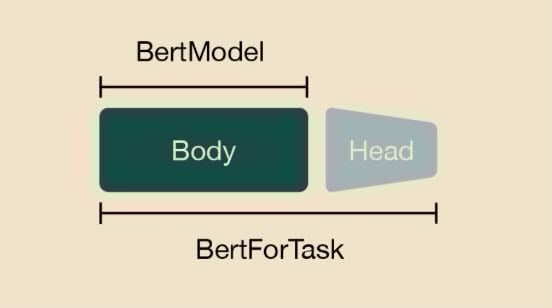

#Creating a Custom Model for Token Classification

In [23]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [24]:
# we use RoBerta as the base model, but augmented with settings specific to XLM-R
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    # Load model body
    self.roberta = RobertaModel(config, add_pooling_layer = False)
    # Set add_pooling_layer = False to ensure all hidden states are returned
    # and not only the one associated with the [CLS] token

    # Set up token classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    # Load and initialize weights
    self.init_weights()

  def forward(self, input_ids = None,
              attention_mask = None,
              token_type_ids = None,
              labels = None, **kwargs):
    # Get outputs (encoder representations) of model body
    outputs = self.roberta(input_ids, attention_mask = attention_mask,
                           token_type_ids = token_type_ids, **kwargs)

    # Define model head (classifier for encoder representation)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)

    # Calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    # Return model output object
    return TokenClassifierOutput(loss = loss, logits = logits,
                                 hidden_states = outputs.hidden_states,
                                 attentions = outputs.attentions)

In [25]:
print(XLMRobertaForTokenClassification.__dict__)

{'__module__': '__main__', 'config_class': <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'>, '__init__': <function XLMRobertaForTokenClassification.__init__ at 0x7c6e262e15a0>, 'forward': <function XLMRobertaForTokenClassification.forward at 0x7c6e262e2710>, '__doc__': None}


# Loading a Custom model

In [26]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [27]:
# Load config by AutoConfig
from transformers import AutoConfig

In [28]:
# View original config
xlmr_config_ori = AutoConfig.from_pretrained(xlmr_model_name)
xlmr_config_ori

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [29]:
# View customize config
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag,
                                         label2id = tag2index)

In [30]:
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [31]:
import torch

In [32]:
# Load the model weights by inheriting from RobertaPreTrainedModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config = xlmr_config)
              .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = 'pt')
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [34]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [35]:
# Predict the input
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f'Number of tokens in sequence: {len(xlmr_tokens)}')
print(f'Shape of outputs: {outputs.shape}')

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [36]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


In [37]:
# define function to predict
def tag_text(text, tags, model, tokenizer):
  # Get tokens with special characters
  tokens = tokenizer(text).tokens()
  # Encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors = 'pt').input_ids.to(device)
  # Get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # Take argmax to get most likely class per token
  predictions = torch.argmax(outputs, dim = 2)
  # Convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index = ['Tokens', 'Tags'])

In [38]:
tag_text("I love you so much, but this love is just from me.",
         tags,
         xlmr_model,
         xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁I,▁love,▁you,▁so,▁much,",",▁but,▁this,▁love,▁is,▁just,▁from,▁me,.,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


# Tokenizer texts for NER

In [39]:
de_example

{'tokens': ['Dirigenten',
  'von',
  'Weltruf',
  'wie',
  'Wilhelm',
  'Furtwängler',
  ',',
  'Erich',
  'Kleiber',
  ',',
  'Wolfgang',
  'Sawallisch',
  ',',
  'Karl',
  'Böhm',
  ',',
  'Herbert',
  'von',
  'Karajan',
  ',',
  'Rafael',
  'Kubelík',
  ',',
  'Erich',
  'Kleiber',
  ',',
  'Bernard',
  'Haitink',
  ',',
  'Josef',
  'Krips',
  ',',
  'Zubin',
  'Mehta',
  ',',
  'Dimitri',
  'Mitropoulos',
  ',',
  'Antal',
  'Doráti',
  ',',
  'Sergiu',
  'Celibidache',
  'und',
  'andere',
  'haben',
  'seine',
  'Werke',
  'dirigiert',
  ',',
  'zuletzt',
  'besonders',
  'Horst',
  'Stein',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',


In [40]:
words, labels = de_example['tokens'], de_example['ner_tags']

In [41]:
print(words)

['Dirigenten', 'von', 'Weltruf', 'wie', 'Wilhelm', 'Furtwängler', ',', 'Erich', 'Kleiber', ',', 'Wolfgang', 'Sawallisch', ',', 'Karl', 'Böhm', ',', 'Herbert', 'von', 'Karajan', ',', 'Rafael', 'Kubelík', ',', 'Erich', 'Kleiber', ',', 'Bernard', 'Haitink', ',', 'Josef', 'Krips', ',', 'Zubin', 'Mehta', ',', 'Dimitri', 'Mitropoulos', ',', 'Antal', 'Doráti', ',', 'Sergiu', 'Celibidache', 'und', 'andere', 'haben', 'seine', 'Werke', 'dirigiert', ',', 'zuletzt', 'besonders', 'Horst', 'Stein', '.']


In [42]:
print(labels)

[0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0]


In [43]:
# View tokens from xlmr
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=['Tokens'])

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>


In [44]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ['Tokens', 'Word IDS'])

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>
Word IDS,None,0,0,1,2,2,3,4,5,5,...,49,49,50,51,52,52,53,54,54,None


In [45]:
# Set -100 as the label for special tokens and subwords we wish to mask during training.
# Special tokens: <s>, </s>, ...
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else 'IGN' for l in label_ids]
index = ['Tokens', 'Word IDs', 'Label IDs', 'Labels']

pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Tokens,<s>,▁Dirigent,en,▁von,▁Welt,ruf,▁wie,▁Wilhelm,▁Fur,tw,...,▁,",",▁zuletzt,▁besonders,▁Hor,st,▁Stein,▁,.,</s>
Word IDs,None,0,0,1,2,2,3,4,5,5,...,49,49,50,51,52,52,53,54,54,None
Label IDs,-100,0,-100,0,0,-100,0,1,2,-100,...,0,-100,0,0,1,-100,2,0,-100,-100
Labels,IGN,O,IGN,O,O,IGN,O,B-PER,I-PER,IGN,...,O,IGN,O,O,B-PER,IGN,I-PER,O,IGN,IGN


In [46]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation = True,
                                    is_split_into_words = True)
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index = idx)
    previous_word_ids = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_ids:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_ids = word_idx
    labels.append(label_ids)
  tokenized_inputs['labels'] = labels
  return tokenized_inputs

In [47]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched = True,
                    remove_columns = ['langs', 'ner_tags', 'tokens'])

In [48]:
panx_de_encoded = encode_panx_dataset(panx_ch['de'])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [49]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

# Performance measures

In [50]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=e7fa3109478c40550e5d581c43069657f659b8e63f2ab7dbcda3ce6c5e919410
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [51]:
# Example of evaluate
from seqeval.metrics import classification_report

In [52]:
y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [53]:
import numpy as np

In [54]:
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis = 2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

      labels_list.append(example_labels)
      preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-Tuning XLMR-RoBERTa

In [55]:
from transformers import TrainingArguments

In [56]:
num_epochs = 3
batch_size = 6
logging_steps = len(panx_de_encoded['train']) // batch_size
model_name = f'{xlmr_model_name}-fintuned-panx-de-23072024'
training_args = TrainingArguments(
    output_dir = model_name,
    log_level = 'error',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    evaluation_strategy = 'epoch',
    save_steps = 1e6, weight_decay = 0.01,
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [57]:
from huggingface_hub import notebook_login

In [58]:
notebook_login()

In [59]:
from seqeval.metrics import f1_score

In [60]:
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  return {'f1': f1_score(y_true, y_pred)}

In [61]:
from transformers import DataCollatorForTokenClassification

In [62]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [63]:
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config = xlmr_config)
          .to(device))

In [64]:
from transformers import Trainer

In [65]:
trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics,
                  train_dataset = panx_de_encoded['train'],
                  eval_dataset = panx_de_encoded['validation'],
                  tokenizer = xlmr_tokenizer)

In [67]:
trainer.train()
# trainer.push_to_hub(commit_message = 'Init model, training completed!')
trainer.push_to_hub = False

Epoch,Training Loss,Validation Loss,F1
1,0.253900,0.153871,1.000000
2,0.126800,0.140541,1.000000
3,0.079400,0.139071,1.000000


In [68]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# Error analysis
Investigate the errors of model.
Why do we need to do that?
There are several failure modes where it might look like the model is performing well, while in practice it has some serious flaws.
Some training can fail include:
- Mask too many tokens and also mask some of our labels to get a really promising loss drop.
- The compute_metrics() function might have a bug that overestimates the true performance.
- With a lot of 0 entities or zero classes, it will be ambigious because 0 classes are the majority class by a large margin.

In [66]:
from torch.nn.functional import cross_entropy

In [67]:
def forward_pass_with_label(batch):
  # Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # Pad inputs and labels and put all tensprs on
  batch = data_collator(features)
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  labels = batch['labels'].to(device)
  with torch.no_grad():
    # Pass data through model
    output = trainer.model(input_ids, attention_mask)
    # logit.size: [batch_size, sequence_length, classes]
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, dim = -1)
  # Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1,7),
                       labels.view(-1), reduction = 'none')
  # Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()
  return {'loss': loss, 'predicted_label': predicted_label}

In [68]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [69]:
# This code is used to reload model from huggingface. If you don't reload, please across it.
model_loaded = AutoModelForTokenClassification.from_pretrained("Tkag/xlm-roberta-base-fintuned-panx-de-23072024")

config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [70]:
# This code is used to reload model from huggingface. If you don't reload, please across it.
trainer = Trainer(model = model_loaded, args = training_args,
                  compute_metrics = compute_metrics,
                  data_collator = data_collator)
trainer.model = model_loaded.to(device)

In [71]:
valid_set = panx_de_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched = True, batch_size = 32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [76]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00026258358, 0.0, 0.0, 0.0, 0.0, 1.516...","[6, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.0001212285, 9.4647694e-05, 0.000112408...","[0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00015531764, 0.00014804698, 0.00016187...","[5, 0, 0, 0, 5, 6, 0, 0, 5, 5, 5, 5, 5, 5, 5, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00011109689, 0.00011276563, 0.00011169...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."
...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, -10...","[0.0, 9.8700424e-05, 8.964137e-05, 9.4647694e-...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, ..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, -100, -100, 6, 6, 6, 6, -100]","[0.0, 0.006400562, 0.0, 0.0, 0.007294095, 0.00...","[6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.00010287233, 0.00010096517, 0.00010561...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, -100, 0, 0, 5, 6, 0, 0, -100, -100]","[0.0, 0.00018106251, 0.0007375143, 0.0, 0.0001...","[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, ..."


In [77]:
type(df)

pandas.core.frame.DataFrame

In [78]:
# Convert to view easily
index2tag[-100] = 'IGN'
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)

In [79]:
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [80]:
# Show a dataframe about tokens
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
...,...,...,...,...,...,...
6289,242,1,O,0.00,O,▁'
6289,5106,1,O,0.00,O,▁''
6289,223660,1,B-PER,2.88,B-LOC,▁Alabama
6289,5106,1,O,0.00,O,▁''


In [81]:
# group and aggregate the losses for each token
(df_tokens.groupby('input_tokens')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level = 0, axis = 1)
 .sort_values(by = 'sum', ascending = False)
 .reset_index()
 .round(2)
 .head(10)
 .T)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁(,▁und,▁),▁'',▁die
count,6066,989,1388,808,163,246,1171,246,2898,860
mean,0.03,0.14,0.09,0.14,0.64,0.32,0.07,0.31,0.03,0.06
sum,205.19,136.77,127.08,113.73,103.89,79.13,76.95,76.39,75.53,53.74


In [82]:
(df_tokens.groupby('labels')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level = 0, axis = 1)
 .sort_values(by = 'sum', ascending = False)
 .reset_index()
 .round(2)
 .T)

,0,1,2,3,4,5,6
labels,I-ORG,B-ORG,O,B-LOC,I-LOC,I-PER,B-PER
count,3820,2683,43648,3172,1462,4139,2893
mean,0.52,0.6,0.03,0.32,0.62,0.18,0.26
sum,1989.73,1600.7,1347.36,1012.79,909.35,758.01,756.77


In [70]:
# Evaluate with confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [71]:
from matplotlib import pyplot as plt

In [74]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize = 'true')
  fig, ax = plt.subplots(figsize = (10,10))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  disp.plot(cmap = 'Blues', values_format = '.2f', ax = ax, colorbar = False)
  plt.title('Normalized confusion matrix')
  plt.show()

In [86]:
df_tokens.columns

Index(['input_ids', 'attention_mask', 'labels', 'loss', 'predicted_label',
       'input_tokens'],
      dtype='object')

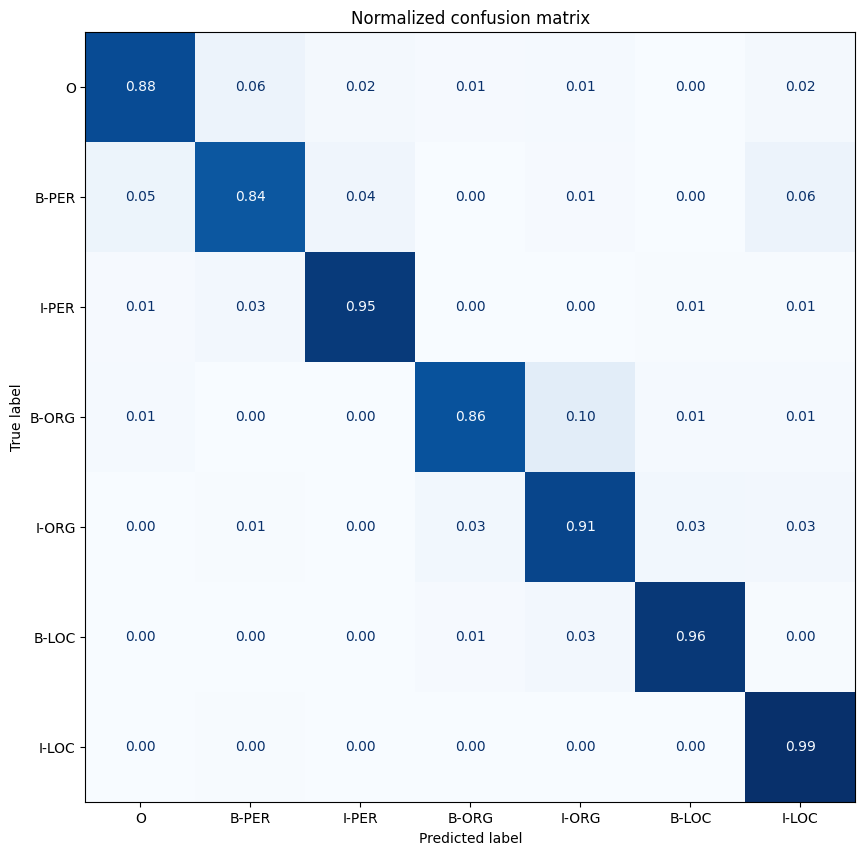

In [87]:
plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

In [72]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row['attention_mask']):
      if i not in {0, len(row['attention_mask'])}:
        labels.append(row['labels'][i])
        preds.append(row['predicted_label'][i])
        tokens.append(row['input_tokens'][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                           "preds": preds, "losses": losses}).T
    yield df_tmp

In [89]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by = 'total_loss', ascending = False).head(5)

for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,5.78,0.00,0.00,0.00,10.44,10.45,9.96,9.71,10.32,0.00,9.86,10.26,0.00,10.03,10.21,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.07,0.00,0.00,8.97,9.15,9.48,6.94,0.00,7.85,9.48,7.72,7.53,5.88,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.99,6.24,6.07,0.00,6.03,0.00,5.76,0.00,5.81,5.64,5.80,6.07,6.15,6.09,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁1988,▁in,▁Auckland,▁und,▁1989,▁in,▁Stavanger,▁tru,g,▁er,▁mit,▁einem,▁sie,b,ten,▁bzw,▁,.,</s>
labels,B-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,IGN,O,O,O,O,IGN,IGN,O,O,IGN,IGN
preds,O,O,B-LOC,O,O,O,B-LOC,O,O,O,O,O,O,O,O,O,O,O,O
losses,6.97,10.43,6.80,0.00,6.77,10.31,6.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
tokens,▁Im,▁Jahr,▁2006,▁spielt,e,▁sie,▁in,▁einigen,▁Folgen,▁der,...,▁'',Bro,oke,▁'',▁über,nah,m,▁,.,</s>
labels,O,O,O,O,IGN,O,O,O,O,O,...,O,IGN,IGN,O,O,IGN,IGN,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.06,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00


In [90]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u'\u2581(' in x)].head(5)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


,0,1,2,3,4,5,6,7,8,9,10,11
tokens,▁Pik,e,▁Town,ship,▁(,▁Brown,▁County,▁,",",▁Ohio,▁),</s>
labels,B-LOC,IGN,I-LOC,IGN,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.01,0.00


,0,1,2,3,4,5,6
tokens,▁Bad,▁Grund,▁(,▁Har,z,▁),</s>
labels,B-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.01,0.01,0.01,0.01,0.00,0.01,0.00


,0,1,2,3,4,5,6,7,8
tokens,▁Al,fon,s,▁VI,.,▁(,▁León,▁),</s>
labels,B-PER,IGN,IGN,I-PER,IGN,I-PER,I-PER,I-PER,IGN
preds,B-PER,B-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Cross-Lingual Transfer

In [91]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [73]:
def get_loss_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_loss"]

In [92]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded['test'])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 1.000


In [93]:
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 1.000


In [94]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [95]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds['test'])

In [74]:
def evaluate_lang_performance_loss_score(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_loss_score(trainer, panx_ds['test'])

In [96]:
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] datset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] datset: 1.000


In [97]:
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] datset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] datset: 1.000


In [98]:
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] datset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] datset: 1.000


In [99]:
f1_scores

defaultdict(dict, {'de': {'de': 1.0, 'fr': 1.0, 'it': 1.0, 'en': 1.0}})

In [78]:
loss_scores = defaultdict(dict)
loss_scores["de"]["de"] = get_loss_score(trainer, panx_de_encoded['test'])
print(f"Loss-score of [de] model on [de] dataset: {loss_scores['de']['de']:.3f}")

Loss-score of [de] model on [de] dataset: 0.140


In [121]:
loss_scores["de"]["fr"] = get_loss_score(trainer, panx_de_encoded['test'])
print(f"Loss-score of [de] model on [fr] dataset: {loss_scores['de']['fr']:.3f}")

Loss-score of [de] model on [fr] dataset: 0.140


In [122]:
loss_scores["de"]["it"] = get_loss_score(trainer, panx_de_encoded['test'])
print(f"Loss-score of [de] model on [it] dataset: {loss_scores['de']['it']:.3f}")

Loss-score of [de] model on [it] dataset: 0.140


In [123]:
loss_scores["de"]["en"] = get_loss_score(trainer, panx_de_encoded['test'])
print(f"Loss-score of [de] model on [en] dataset: {loss_scores['de']['en']:.3f}")

Loss-score of [de] model on [en] dataset: 0.140


# When Does Zero-Shot Transfer Make Sense

In [100]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset['train'].shuffle().select(range(num_samples))
  valid_ds = dataset['validation']
  test_ds = dataset['test']
  training_args.logging_steps = len(train_ds)//batch_size

  trainer = Trainer(model_init = model_init, args = training_args,
                    data_collator = data_collator, compute_metrics = compute_metrics,
                    train_dataset = train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message = f"Training completed!")

  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [75]:
def train_on_subset_loss(dataset, num_samples):
  train_ds = dataset['train'].shuffle().select(range(num_samples))
  valid_ds = dataset['validation']
  test_ds = dataset['test']
  training_args.logging_steps = len(train_ds)//batch_size

  trainer = Trainer(model_init = model_init, args = training_args,
                    data_collator = data_collator, compute_metrics = compute_metrics,
                    train_dataset = train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message = f"Training completed!")

  loss_score = get_loss_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "loss_score": [loss_score]})

In [78]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

In [79]:
panx_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
})

In [103]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.611400,1.302332,0.000000
2,1.186100,1.002813,0.000000
3,0.996400,0.926670,0.000000


,num_samples,f1_score
0,250,0.0


Epoch,Training Loss,Validation Loss,F1
1,1.424700,1.032997,0.000000
2,0.868600,0.663675,1.000000
3,0.594300,0.572499,1.000000


Epoch,Training Loss,Validation Loss,F1
1,1.070700,0.550981,0.000000
2,0.452200,0.420656,0.000000
3,0.301100,0.392806,1.000000


Epoch,Training Loss,Validation Loss,F1
1,0.774600,0.425947,0.000000
2,0.321700,0.344122,1.000000
3,0.204100,0.333724,1.000000


Epoch,Training Loss,Validation Loss,F1
1,0.646100,0.367399,0.000000
2,0.286200,0.299357,1.000000
3,0.189700,0.298874,1.000000


Epoch,Training Loss,Validation Loss,F1
1,0.587900,0.336354,1.000000
2,0.274500,0.304830,1.000000
3,0.178800,0.285479,1.000000


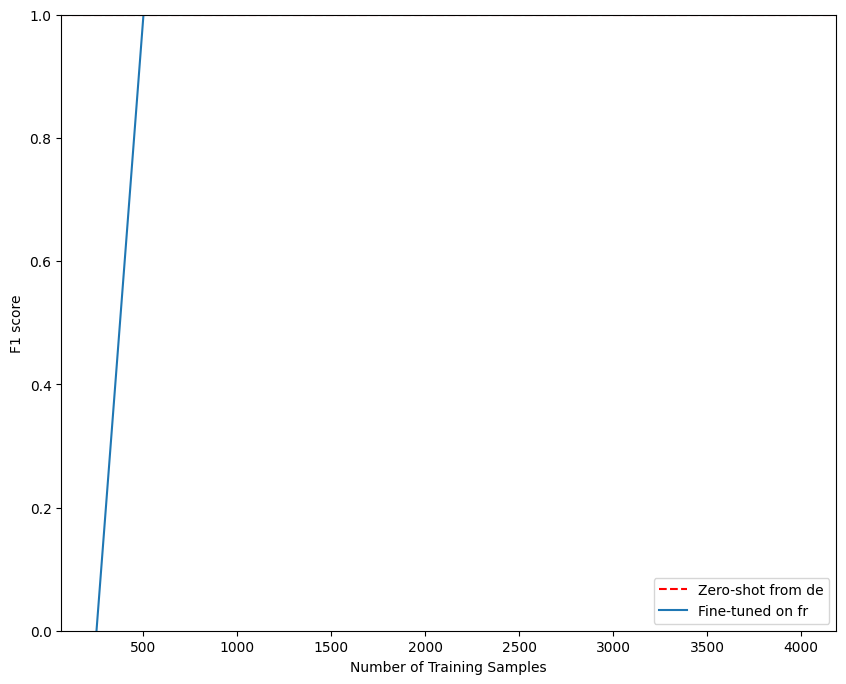

In [104]:
for num_samples in [500, 1000, 2000, 3000, 4000]:
  metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)],
                                 ignore_index = True)

fig, ax = plt.subplots(figsize = (10, 8))
ax.axhline(f1_scores['de']['fr'], ls = '--', color = 'r')
metrics_df.set_index('num_samples').plot(ax = ax)
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc = 'lower right')
plt.ylim((0,1))
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 score')
plt.show()

In [80]:
metrics_df_loss = train_on_subset_loss(panx_fr_encoded, 250)
metrics_df_loss

Epoch,Training Loss,Validation Loss,F1
1,1.319200,0.907894,0.000000
2,0.680900,0.568885,1.000000
3,0.408500,0.528764,1.000000


events.out.tfevents.1721989601.52ee929e7106.2210.0:   0%|          | 0.00/7.12k [00:00<?, ?B/s]

,num_samples,loss_score
0,250,0.507501


In [1]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df_loss = pd.concat([metrics_df_loss, train_on_subset_loss(panx_fr_encoded, num_samples)],
                                 ignore_index = True)

fig, ax = plt.subplots(figsize = (10, 8))
ax.axhline(loss_scores['de']['fr'], ls = '--', color = 'r')
metrics_df_loss.set_index('num_samples').plot(ax = ax)
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc = 'lower right')
plt.ylim((0,1))
plt.xlabel('Number of Training Samples')
plt.ylabel('Loss score')
plt.show()

NameError: name 'pd' is not defined

In [109]:
predicted_res = trainer.predict(panx_de_encoded['test'])

In [110]:
predicted_res.metrics

{'test_loss': 0.1401020735502243,
 'test_f1': 1.0,
 'test_runtime': 19.0529,
 'test_samples_per_second': 330.134,
 'test_steps_per_second': 41.306}